# Wind Forecasting

## Data Preparation

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
data = pd.read_excel(r"3.Jafrabad_Coastal_mast_data_Dec_2018_to_Nov_2019.xlsx")

df = pd.DataFrame(data)

print(df)

                Date/Time  100m_N Avg [m/s]  100m_S Avg [m/s]  80m Avg [m/s]  \
0     2018-12-01 00:00:00            10.654            10.809          5.182   
1     2018-12-01 00:10:00            10.531            10.688          5.334   
2     2018-12-01 00:20:00             9.976            10.110          5.319   
3     2018-12-01 00:30:00             9.617             9.735          5.319   
4     2018-12-01 00:40:00             9.001             9.112          5.363   
...                   ...               ...               ...            ...   
52555 2019-11-30 23:10:00             5.852               NaN          5.790   
52556 2019-11-30 23:20:00             6.822               NaN          6.529   
52557 2019-11-30 23:30:00             7.231               NaN          6.720   
52558 2019-11-30 23:40:00             7.866               NaN          7.152   
52559 2019-11-30 23:50:00             7.224               NaN          6.622   

       50m Avg [m/s]  20m Avg [m/s]  10

## Data Preprocessing

In [2]:
df.rename(columns={'100m_N Avg [m/s]': '100m Avg[m/s]'}, inplace=True)

# Drop the '100m_S Avg [m/s]' column
df.drop(columns=['100m_S Avg [m/s]'], inplace=True)

print("\nDataFrame after renaming '100m_N Avg [m/s]' to '100m Avg[m/s]' and dropping '100m_S Avg [m/s]' column:")
print(df)




DataFrame after renaming '100m_N Avg [m/s]' to '100m Avg[m/s]' and dropping '100m_S Avg [m/s]' column:
                Date/Time  100m Avg[m/s]  80m Avg [m/s]  50m Avg [m/s]  \
0     2018-12-01 00:00:00         10.654          5.182          7.096   
1     2018-12-01 00:10:00         10.531          5.334          7.415   
2     2018-12-01 00:20:00          9.976          5.319          7.398   
3     2018-12-01 00:30:00          9.617          5.319          7.430   
4     2018-12-01 00:40:00          9.001          5.363          7.344   
...                   ...            ...            ...            ...   
52555 2019-11-30 23:10:00          5.852          5.790          3.549   
52556 2019-11-30 23:20:00          6.822          6.529          4.855   
52557 2019-11-30 23:30:00          7.231          6.720          5.223   
52558 2019-11-30 23:40:00          7.866          7.152          5.826   
52559 2019-11-30 23:50:00          7.224          6.622          4.713   

       

In [3]:
df.isnull().sum()

Date/Time                0
100m Avg[m/s]           59
80m Avg [m/s]         7473
50m Avg [m/s]           59
20m Avg [m/s]         3213
10m Avg [m/s]         9222
Pressure 5m [mbar]      59
98m WV [°]            6441
78m WV [°]            6441
48m WV [°]            6441
Temp 5m [°C]          6446
Hum 5m                6441
dtype: int64

Mean values (Wind direction and 10m)

In [4]:
mean_value = df['10m Avg [m/s]'].mean()

# Fill missing values with the calculated mean
df['10m Avg [m/s]'].fillna(mean_value, inplace=True)

# Print updated DataFrame
print("\nDataFrame after filling missing values with mean for feature '{}':".format('10m Avg [m/s]'))
print(df)

def replace_nan_with_mean(df, columns):
    for column in columns:
        if df[column].isnull().sum() > 0:
            mean_value = df[column].mean()
            df[column].fillna(mean_value, inplace=True)
    return df

# Specify the features you want to take the mean value
features_to_replace = ['98m WV [°]','78m WV [°]','48m WV [°]']

# Replace NaN values with mean for specified features
df = replace_nan_with_mean(df, features_to_replace)


DataFrame after filling missing values with mean for feature '10m Avg [m/s]':
                Date/Time  100m Avg[m/s]  80m Avg [m/s]  50m Avg [m/s]  \
0     2018-12-01 00:00:00         10.654          5.182          7.096   
1     2018-12-01 00:10:00         10.531          5.334          7.415   
2     2018-12-01 00:20:00          9.976          5.319          7.398   
3     2018-12-01 00:30:00          9.617          5.319          7.430   
4     2018-12-01 00:40:00          9.001          5.363          7.344   
...                   ...            ...            ...            ...   
52555 2019-11-30 23:10:00          5.852          5.790          3.549   
52556 2019-11-30 23:20:00          6.822          6.529          4.855   
52557 2019-11-30 23:30:00          7.231          6.720          5.223   
52558 2019-11-30 23:40:00          7.866          7.152          5.826   
52559 2019-11-30 23:50:00          7.224          6.622          4.713   

       20m Avg [m/s]  10m Avg [m

In [5]:
df.isnull().sum()

Date/Time                0
100m Avg[m/s]           59
80m Avg [m/s]         7473
50m Avg [m/s]           59
20m Avg [m/s]         3213
10m Avg [m/s]            0
Pressure 5m [mbar]      59
98m WV [°]               0
78m WV [°]               0
48m WV [°]               0
Temp 5m [°C]          6446
Hum 5m                6441
dtype: int64

Kalman_Interpolation (for wind speed)

In [6]:
from pykalman import KalmanFilter
def kalman_interpolation(df, feature):
    # Extract the series with missing values
    values = df[feature].values

    # Create a Kalman Filter with default parameters
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    
    # Fit the Kalman Filter to the observed values
    values = np.ma.masked_invalid(values)
    kf = kf.em(values, n_iter=10)

    # Apply the Kalman Filter to fill missing values
    smoothed_values, _ = kf.smooth(values)
    
    # Return the filled series, reshaped to 1D
    return pd.Series(smoothed_values.flatten(), index=df.index)

# Apply Kalman interpolation for each feature with missing values
features_with_missing_values = ['100m Avg[m/s]', '80m Avg [m/s]', '50m Avg [m/s]', '20m Avg [m/s]', '10m Avg [m/s]']
for feature in features_with_missing_values:
    df[feature] = kalman_interpolation(df, feature)

print("\nDataFrame after Kalman interpolation for features with missing values:")
print(df.head()) 


DataFrame after Kalman interpolation for features with missing values:
            Date/Time  100m Avg[m/s]  80m Avg [m/s]  50m Avg [m/s]  \
0 2018-12-01 00:00:00      10.492830       5.170974       7.119176   
1 2018-12-01 00:10:00      10.423486       5.298926       7.343877   
2 2018-12-01 00:20:00       9.986350       5.316210       7.388183   
3 2018-12-01 00:30:00       9.584619       5.324690       7.407588   
4 2018-12-01 00:40:00       9.072119       5.351123       7.370149   

   20m Avg [m/s]  10m Avg [m/s]  Pressure 5m [mbar]  98m WV [°]  78m WV [°]  \
0       4.823292       4.139599              1012.2        52.0        45.0   
1       4.886258       4.156705              1012.1        53.4        47.8   
2       4.814378       4.161318              1012.2        53.4        46.4   
3       4.779628       4.162562              1012.1        52.0        46.4   
4       4.806760       4.162898              1012.0        53.4        47.8   

   48m WV [°]  Temp 5m [°C]  Hum

In [7]:
df.isnull().sum()

Date/Time                0
100m Avg[m/s]            0
80m Avg [m/s]            0
50m Avg [m/s]            0
20m Avg [m/s]            0
10m Avg [m/s]            0
Pressure 5m [mbar]      59
98m WV [°]               0
78m WV [°]               0
48m WV [°]               0
Temp 5m [°C]          6446
Hum 5m                6441
dtype: int64

In [8]:
pip install tsmoothie


[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: C:\Users\Dhina\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Na_MA Inteprolation (Other features)

In [9]:

def na_ma_interpolation(df, feature, window=5):
    # Interpolate missing values using linear interpolation first
    df[feature] = df[feature].interpolate(method='linear', limit_direction='both')
    
    # Apply moving average to smooth the interpolated values
    df[feature] = df[feature].rolling(window=window, min_periods=1).mean()

    return df[feature]

# Features to interpolate with MA interpolation
ma_features = ['Pressure 5m [mbar]', 'Temp 5m [°C]', 'Hum 5m']

# Apply MA interpolation for the specified features
for feature in ma_features:
    df[feature] = na_ma_interpolation(df, feature)

# Print updated DataFrame
print("\nDataFrame after applying MA interpolation:")
print(df.head())


DataFrame after applying MA interpolation:
            Date/Time  100m Avg[m/s]  80m Avg [m/s]  50m Avg [m/s]  \
0 2018-12-01 00:00:00      10.492830       5.170974       7.119176   
1 2018-12-01 00:10:00      10.423486       5.298926       7.343877   
2 2018-12-01 00:20:00       9.986350       5.316210       7.388183   
3 2018-12-01 00:30:00       9.584619       5.324690       7.407588   
4 2018-12-01 00:40:00       9.072119       5.351123       7.370149   

   20m Avg [m/s]  10m Avg [m/s]  Pressure 5m [mbar]  98m WV [°]  78m WV [°]  \
0       4.823292       4.139599         1012.200000        52.0        45.0   
1       4.886258       4.156705         1012.150000        53.4        47.8   
2       4.814378       4.161318         1012.166667        53.4        46.4   
3       4.779628       4.162562         1012.150000        52.0        46.4   
4       4.806760       4.162898         1012.120000        53.4        47.8   

   48m WV [°]  Temp 5m [°C]     Hum 5m  
0        29.5     2

In [10]:
df_round = df.round(2)
df_round

,Date/Time,100m Avg[m/s],80m Avg [m/s],50m Avg [m/s],20m Avg [m/s],10m Avg [m/s],Pressure 5m [mbar],98m WV [°],78m WV [°],48m WV [°],Temp 5m [°C],Hum 5m
0,2018-12-01 00:00:00,10.49,5.17,7.12,4.82,4.14,1012.20,52.0,45.0,29.5,22.50,46.50
1,2018-12-01 00:10:00,10.42,5.30,7.34,4.89,4.16,1012.15,53.4,47.8,32.3,22.35,47.00
2,2018-12-01 00:20:00,9.99,5.32,7.39,4.81,4.16,1012.17,53.4,46.4,29.5,22.27,47.43
3,2018-12-01 00:30:00,9.58,5.32,7.41,4.78,4.16,1012.15,52.0,46.4,30.9,22.25,47.70
4,2018-12-01 00:40:00,9.07,5.35,7.37,4.81,4.16,1012.12,53.4,47.8,32.3,22.24,47.96
...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2019-11-30 23:10:00,5.96,5.81,3.91,3.57,2.78,1009.90,9.8,2.8,351.6,-30.00,20.60
52556,2019-11-30 23:20:00,6.74,6.42,4.72,3.21,2.70,1009.90,15.5,7.0,0.0,-30.00,20.04
52557,2019-11-30 23:30:00,7.22,6.71,5.17,3.36,2.84,1009.88,15.5,8.4,0.0,-30.00,19.44
52558,2019-11-30 23:40:00,7.65,6.98,5.48,3.32,2.85,1009.84,16.9,8.4,1.4,-30.00,18.78


Range test

In [11]:
def flag_wind_speed(wind_speed_cols, sensor_min, sensor_max, user_min, user_max, df_round):
    flags = []
    for col in wind_speed_cols:
        wind_speed = df_round[col]
        if (wind_speed < sensor_min).any() or (wind_speed > sensor_max).any():
            flags.append(4)  # Fail
        elif (wind_speed < user_min).any() or (wind_speed > user_max).any():
            flags.append(3)  # Suspect
        else:
            flags.append(1)  # Pass
    return flags

def flag_wind_direction(wind_direction_cols, sensor_min, sensor_max, user_min, user_max, df_round):
    flags = []
    for col in wind_direction_cols:
        wind_direction = df_round[col]
        if (wind_direction < sensor_min).any() or (wind_direction > sensor_max).any():
            flags.append(4)  # Fail
        elif (wind_direction < user_min).any() or (wind_direction > user_max).any():
            flags.append(3)  # Suspect
        else:
            flags.append(1)  # Pass
    return flags

sensor_min_wind_speed = 0
sensor_max_wind_speed = 30
user_min_wind_speed = 0
user_max_wind_speed = 40

wind_speed_cols = ["100m Avg[m/s]", "80m Avg [m/s]", "20m Avg [m/s]", "10m Avg [m/s]"]

sensor_min_wind_direction = 0
sensor_max_wind_direction = 360
user_min_wind_direction = 0
user_max_wind_direction = 360

wind_direction_cols = ["98m WV [°]", "78m WV [°]", "48m WV [°]"]

wind_speed_flags = flag_wind_speed(wind_speed_cols, sensor_min_wind_speed, sensor_max_wind_speed, user_min_wind_speed, user_max_wind_speed, df_round)
print("Flags for wind speed:", wind_speed_flags)

wind_direction_flags = flag_wind_direction(wind_direction_cols, sensor_min_wind_direction, sensor_max_wind_direction, user_min_wind_direction, user_max_wind_direction, df_round)
print("Flags for wind direction:", wind_direction_flags)


Flags for wind speed: [1, 1, 1, 1]
Flags for wind direction: [1, 1, 1]


Climatology test(Temperature)

In [12]:
def check_temperature(temperature_cols, min_temp, max_temp, df_round):
    flags = []
    for col in temperature_cols:
        T = df_round[col]
        if (T < min_temp).any() or (T > max_temp).any():
            flags.append(3)  # Fail
        else:
            flags.append(1)  # Pass
    return flags

temperature_cols = ['Temp 5m [°C]']
min_temp = 0  # Lowest in Gujarat = 1.7 C
max_temp = 50  # Highest in Gujarat = 47 C

temperature_flags = check_temperature(temperature_cols, min_temp, max_temp, df_round)
print("Flags for the temperature:", temperature_flags)

Flags for the temperature: [3]


Rate of Change

In [13]:
import pandas as pd

def rate_of_change_test(wind_data, features, N_DEV, TIM_DEV):
    for feature in features:
        # Ensure the feature exists in the DataFrame
        if feature not in wind_data.columns:
            print(f"Feature '{feature}' not found in the DataFrame.")
            continue
        
        # Calculate the first differences of wind speed for the feature
        wind_data[f'{feature}_diff'] = wind_data[feature].diff()
        
        # Calculate the rolling standard deviation of the first differences
        wind_data[f'{feature}_std_diff'] = wind_data[f'{feature}_diff'].rolling(window=TIM_DEV).std()
        
        # Initialize all flags to 1 (Pass)
        wind_data[f'{feature}_flag'] = 1
        
        # Determine the suspect condition based on the threshold
        suspect_condition = wind_data[f'{feature}_diff'].abs() > (N_DEV * wind_data[f'{feature}_std_diff'])
        wind_data.loc[suspect_condition, f'{feature}_flag'] = 3  # Set flag to 3 (Suspect) where condition is met
        
        # Drop intermediate calculation columns if desired
        wind_data.drop(columns=[f'{feature}_diff', f'{feature}_std_diff'], inplace=True)
    
    return wind_data

# Parameters
N_DEV = 3  # Number of standard deviations
TIM_DEV = 5  # Period over which the standard deviation is calculated

# Features to apply the test
features = ['100m Avg[m/s]', '80m Avg [m/s]', '50m Avg [m/s]', '20m Avg [m/s]', '10m Avg [m/s]']

# Apply the rate of change test
df_round = rate_of_change_test(df, features, N_DEV, TIM_DEV)

# Print only the flag columns
flag_columns = [f'{feature}_flag' for feature in features]
print("\nFlag columns after applying the rate of change test:")
print(df_round[flag_columns].head())



Flag columns after applying the rate of change test:
   100m Avg[m/s]_flag  80m Avg [m/s]_flag  50m Avg [m/s]_flag  \
0                   1                   1                   1   
1                   1                   1                   1   
2                   1                   1                   1   
3                   1                   1                   1   
4                   1                   1                   1   

   20m Avg [m/s]_flag  10m Avg [m/s]_flag  
0                   1                   1  
1                   1                   1  
2                   1                   1  
3                   1                   1  
4                   1                   1  


Flat line test

In [14]:
# Define the feature names
feature_names = ['100m Avg[m/s]', '80m Avg [m/s]', '50m Avg [m/s]', '20m Avg [m/s]', '10m Avg [m/s]', '98m WV [°]', '78m WV [°]', '48m WV [°]']

# Define the tolerance and repetition counts
tolerance = 0.001
fail_rep_count = 10
suspect_rep_count = 3

# Define the evaluate_features function
def evaluate_features(observations, tolerance, fail_rep_count, suspect_rep_count):
    flags = {}

    for feature, obs in observations.items():
        if len(obs) < max(fail_rep_count, suspect_rep_count):
            flags[feature] = 1  # Not enough data for comparison, pass by default
            continue

        recent_obs = obs[-max(fail_rep_count, suspect_rep_count):]

        if all(abs(obs[-1] - prev_obs) < tolerance for prev_obs in recent_obs[-fail_rep_count:]):
            flags[feature] = 4  # Fail
        elif all(abs(obs[-1] - prev_obs) < tolerance for prev_obs in recent_obs[-suspect_rep_count:]):
            flags[feature] = 3  # Suspect
        else:
            flags[feature] = 1  # Pass

    return flags

# Create a dictionary to store the observations for each feature
observations = {feature: [] for feature in feature_names}

# Iterate over the rows in the dataset
for index, row in df_round.iterrows():
    # Add the observations to the corresponding feature lists
    for feature in feature_names:
        observations[feature].append(row[feature])

# Evaluate the features using the evaluate_features function
flags = evaluate_features(observations, tolerance, fail_rep_count, suspect_rep_count)

# Print the results
for feature, flag in flags.items():
    if flag == 4:
        print(f"{feature}: Fail")
    elif flag == 3:
        print(f"{feature}: Suspect")
    else:
        print(f"{feature}: Pass")

100m Avg[m/s]: Pass
80m Avg [m/s]: Pass
50m Avg [m/s]: Pass
20m Avg [m/s]: Pass
10m Avg [m/s]: Pass
98m WV [°]: Pass
78m WV [°]: Suspect
48m WV [°]: Pass


In [15]:
import pandas as pd

# assume 'df' is your DataFrame

df_round.to_csv('output.csv', index=False)

## EDA

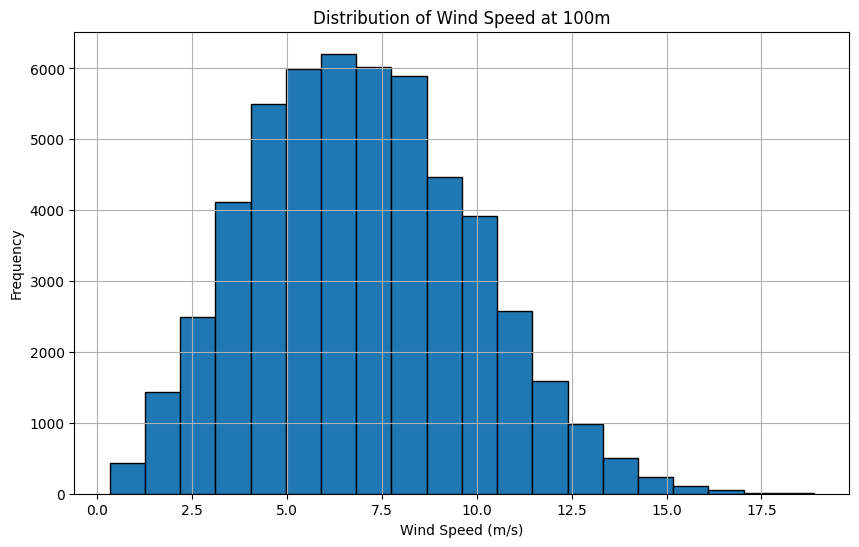

Summary Statistics for Wind Speed at 100m:
count    52560.000000
mean         6.993027
std          2.872756
min          0.341773
25%          4.842827
50%          6.845604
75%          8.948688
max         18.886610
Name: 100m Avg[m/s], dtype: float64


In [16]:
# Example code for distribution and summary statistics
import matplotlib.pyplot as plt

# Visualize distribution of wind speed at 100m
plt.figure(figsize=(10, 6))
plt.hist(df['100m Avg[m/s]'], bins=20, edgecolor='black')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Speed at 100m')
plt.grid(True)
plt.show()

# Calculate summary statistics for wind speed at 100m
print("Summary Statistics for Wind Speed at 100m:")
print(df['100m Avg[m/s]'].describe())


In [17]:
# Example code for correlation analysis
correlation_matrix = df[['10m Avg [m/s]', '20m Avg [m/s]', '50m Avg [m/s]', '80m Avg [m/s]', '100m Avg[m/s]']].corr()

# Plot heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Wind Speeds')
plt.show()


NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

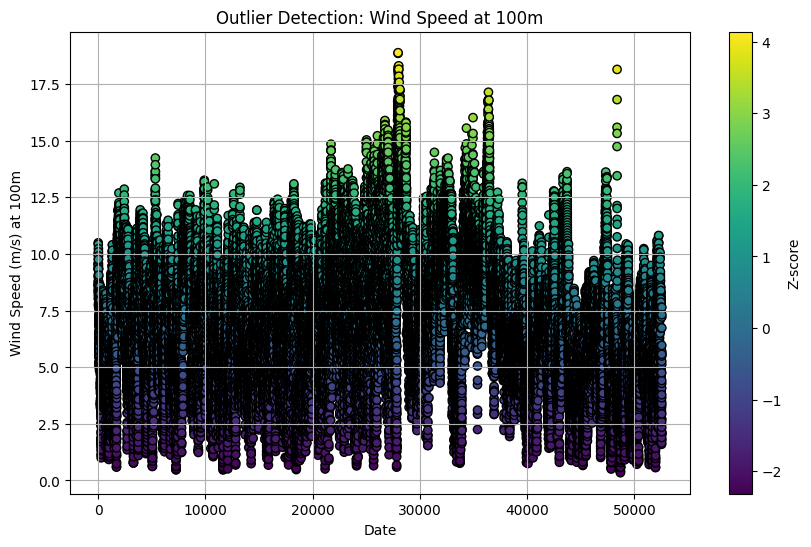

In [18]:
# Example code for outlier detection
from scipy.stats import zscore

# Calculate Z-scores for wind speed at 100m
df['100m_zscore'] = zscore(df['100m Avg[m/s]'])

# Visualize outliers using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['100m Avg[m/s]'], c=df['100m_zscore'], cmap='viridis', edgecolor='k')
plt.colorbar(label='Z-score')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s) at 100m')
plt.title('Outlier Detection: Wind Speed at 100m')
plt.grid(True)
plt.show()


## Building Model

cnn

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense
from keras.callbacks import TensorBoard
import tensorflow as tf

np.random.seed(71)

# Load your data
# Assuming df_round is your preprocessed DataFrame

# Define relevant columns and target column
input_cols = ['80m Avg [m/s]', '50m Avg [m/s]', '20m Avg [m/s]', '10m Avg [m/s]', 
              'Pressure 5m [mbar]', '98m WV [°]', '78m WV [°]', '48m WV [°]', 
              'Temp 5m [°C]', 'Hum 5m']
target_col = ['100m Avg[m/s]']

data_x = df_round[input_cols].values
data_y = df_round[target_col].values

# Define a function to create sequences
def create_dataset(data_x, data_y, look_back=10):
    data_X, data_Y = [], []
    for i in range(len(data_x) - look_back):
        a = data_x[i:(i + look_back)]
        data_X.append(a)
        data_Y.append(data_y[i + look_back - 1])
    return np.array(data_X), np.array(data_Y)

# Create the dataset with a look_back period
look_back = 10
train_size = int(len(data_x) * 0.8)
test_size = len(data_x) - train_size

train_x, test_x = data_x[:train_size], data_x[train_size:]
train_y, test_y = data_y[:train_size], data_y[train_size:]

train_X, train_Y = create_dataset(train_x, train_y, look_back)
test_X, test_Y = create_dataset(test_x, test_y, look_back)

# Reshape the data into 3D arrays for CNN
train_X = np.reshape(train_X, (train_X.shape[0], look_back, len(input_cols)))
test_X = np.reshape(test_X, (test_X.shape[0], look_back, len(input_cols)))

# Define a function to create the CNN model
def create_cnn_model(look_back, input_cols):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back, len(input_cols))))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the CNN model
cnn_model = create_cnn_model(look_back, input_cols)

# Define TensorBoard callback
log_dir = "logs/fit/" + tf.timestamp().numpy().astype(str)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define a custom callback for logging actual vs. predicted values
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_predict = self.model.predict(train_X)
        test_predict = self.model.predict(test_X)

        # Concatenate train and test predictions for consistency with your plotting function
        predict = np.concatenate((train_predict, test_predict))

        # Log the values to TensorBoard
        with tf.summary.create_file_writer(log_dir).as_default():
            tf.summary.scalar('Test RMSE', np.sqrt(np.mean((test_predict - test_Y) ** 2)), step=epoch)
            tf.summary.scalar('Test MAE', np.mean(np.abs(test_predict - test_Y)), step=epoch)
            tf.summary.histogram('Predictions', predict, step=epoch)
            tf.summary.histogram('Actuals', data_y, step=epoch)

# Define a function to train the model
def train_model(model, train_X, train_Y, epochs, batch_size, validation_data, callbacks=None):
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, validation_data=validation_data, callbacks=callbacks)
    return model

# Train the CNN model with TensorBoard and custom callback
cnn_model = train_model(cnn_model, train_X, train_Y, epochs=30, batch_size=15, validation_data=(test_X, test_Y), callbacks=[tensorboard_callback, CustomCallback()])

# Define a function to evaluate the model
def evaluate_model(model, test_X, test_Y):
    test_predict = model.predict(test_X)
    test_score = np.sqrt(np.mean((test_predict - test_Y) ** 2))
    test_mae = np.mean(np.abs(test_predict - test_Y))
    return test_score, test_mae

# Evaluate the CNN model
test_score, test_mae = evaluate_model(cnn_model, test_X, test_Y)
print(f'Test Score: {test_score} RMSE')
print(f'Test Score: {test_mae} MAE')

# Define a function to plot the results
def plot_results(data_y, predict):
    plt.figure(figsize=(40, 6))
    plt.plot(np.arange(len(data_y)), data_y, label='Actual')
    plt.plot(np.arange(len(predict)), predict, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed (m/s)')
    plt.legend()
    plt.show()

# Make predictions using the CNN model
train_predict = cnn_model.predict(train_X)
test_predict = cnn_model.predict(test_X)

# Plot the results
predict = np.concatenate((train_predict, test_predict))
plot_results(data_y, predict)

# Launch TensorBoard
print(f"To view TensorBoard, run the following command in your terminal:\n\n tensorboard --logdir={log_dir}")


KeyboardInterrupt: 

329/329 [==============================] - 1s 1ms/step
Test RMSE: 1.3846331696511402
Test MAE: 1.0557175023333825


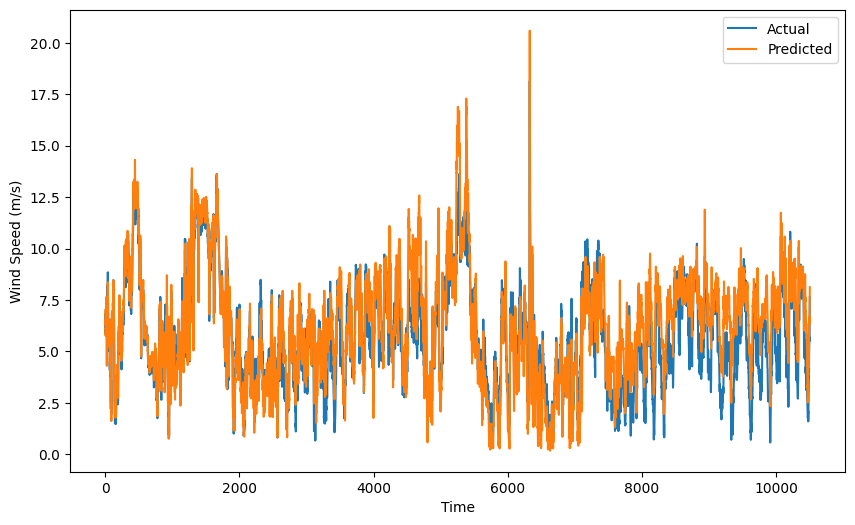

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set seed for reproducibility
np.random.seed(71)

# Assuming df_round is your preprocessed DataFrame
input_cols = ['80m Avg [m/s]', '50m Avg [m/s]', '20m Avg [m/s]', '10m Avg [m/s]', 
              'Pressure 5m [mbar]', '98m WV [°]', '78m WV [°]', '48m WV [°]', 
              'Temp 5m [°C]', 'Hum 5m']
target_col = ['100m Avg[m/s]']

# Load your data and prepare it
data_x = df_round[input_cols].values
data_y = df_round[target_col].values

# Define a function to create sequences
def create_dataset(data_x, data_y, look_back=10):
    data_X, data_Y = [], []
    for i in range(len(data_x) - look_back):
        a = data_x[i:(i + look_back)]
        data_X.append(a)
        data_Y.append(data_y[i + look_back - 1])
    return np.array(data_X), np.array(data_Y)

# Create the dataset with a look_back period
look_back = 10
train_size = int(len(data_x) * 0.8)
test_size = len(data_x) - train_size

train_x, test_x = data_x[:train_size], data_x[train_size:]
train_y, test_y = data_y[:train_size], data_y[train_size:]

train_X, train_Y = create_dataset(train_x, train_y, look_back)
test_X, test_Y = create_dataset(test_x, test_y, look_back)

# Reshape the data into 3D arrays for CNN
train_X = np.reshape(train_X, (train_X.shape[0], look_back, len(input_cols)))
test_X = np.reshape(test_X, (test_X.shape[0], look_back, len(input_cols)))

# Load the pre-trained model
model = load_model('wind_speed_forecasting.h5')

# Compile the model with the same settings
model.compile(optimizer='adam', loss='mean_squared_error')

# Evaluate the model on the test set
test_predict = model.predict(test_X)
test_score_rmse = np.sqrt(mean_squared_error(test_Y, test_predict))
test_score_mae = mean_absolute_error(test_Y, test_predict)

print(f'Test RMSE: {test_score_rmse}')
print(f'Test MAE: {test_score_mae}')

# Save results to a CSV file
results_df = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted': test_predict.flatten()})
results_df.to_excel('predictions.xlsx', index=False)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(test_Y, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()




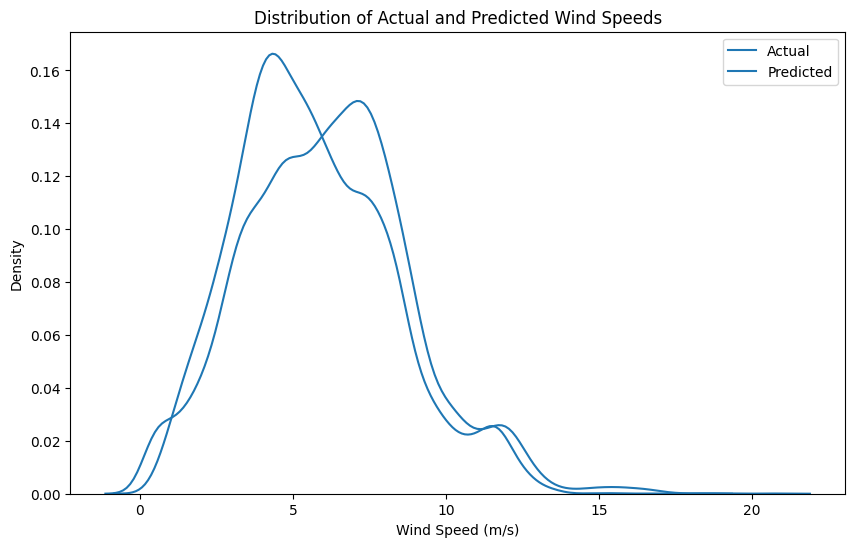

In [37]:
plt.figure(figsize=(10, 6))
sns.kdeplot(test_Y, label='Actual')
sns.kdeplot(test_predict, label='Predicted')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Wind Speeds')
plt.legend()
plt.show()


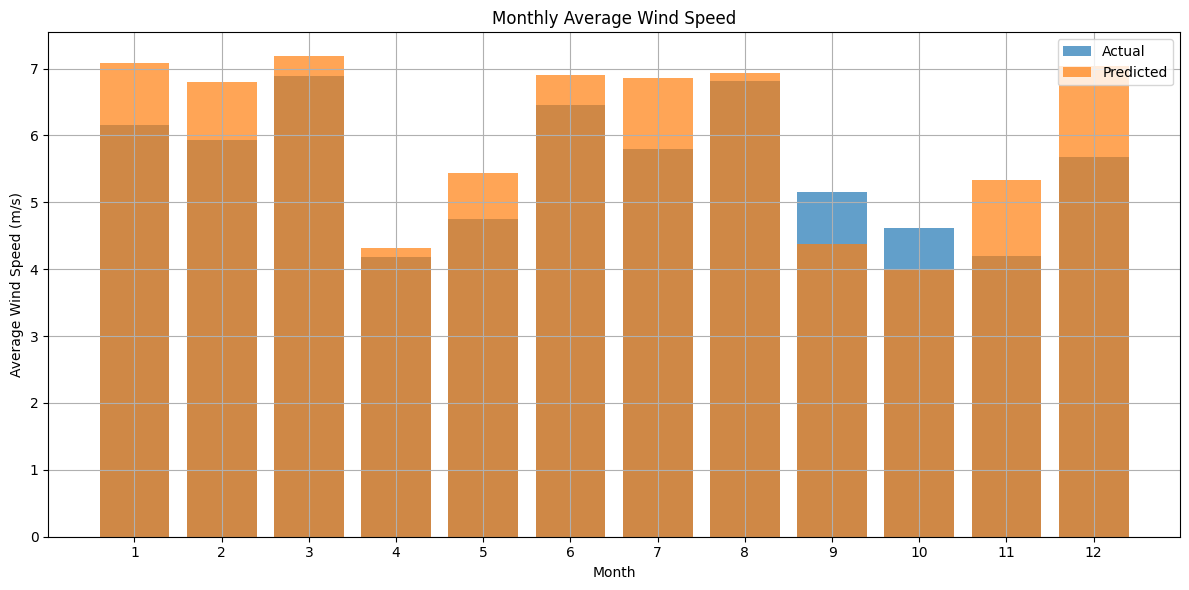

In [42]:
# Assuming 'Date/time' column is available for grouping by month
test_df = pd.DataFrame({'Date/time': pd.date_range('2024-01-01', periods=len(test_Y), freq='H'),
                        'Actual': test_Y.flatten(),
                        'Predicted': test_predict.flatten()})

test_df['Month'] = test_df['Date/time'].dt.month
monthly_avg = test_df.groupby('Month').mean()

plt.figure(figsize=(12, 6))
plt.bar(monthly_avg.index, monthly_avg['Actual'], label='Actual', alpha=0.7)
plt.bar(monthly_avg.index, monthly_avg['Predicted'], label='Predicted', alpha=0.7)
plt.title('Monthly Average Wind Speed')
plt.xlabel('Month')
plt.ylabel('Average Wind Speed (m/s)')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


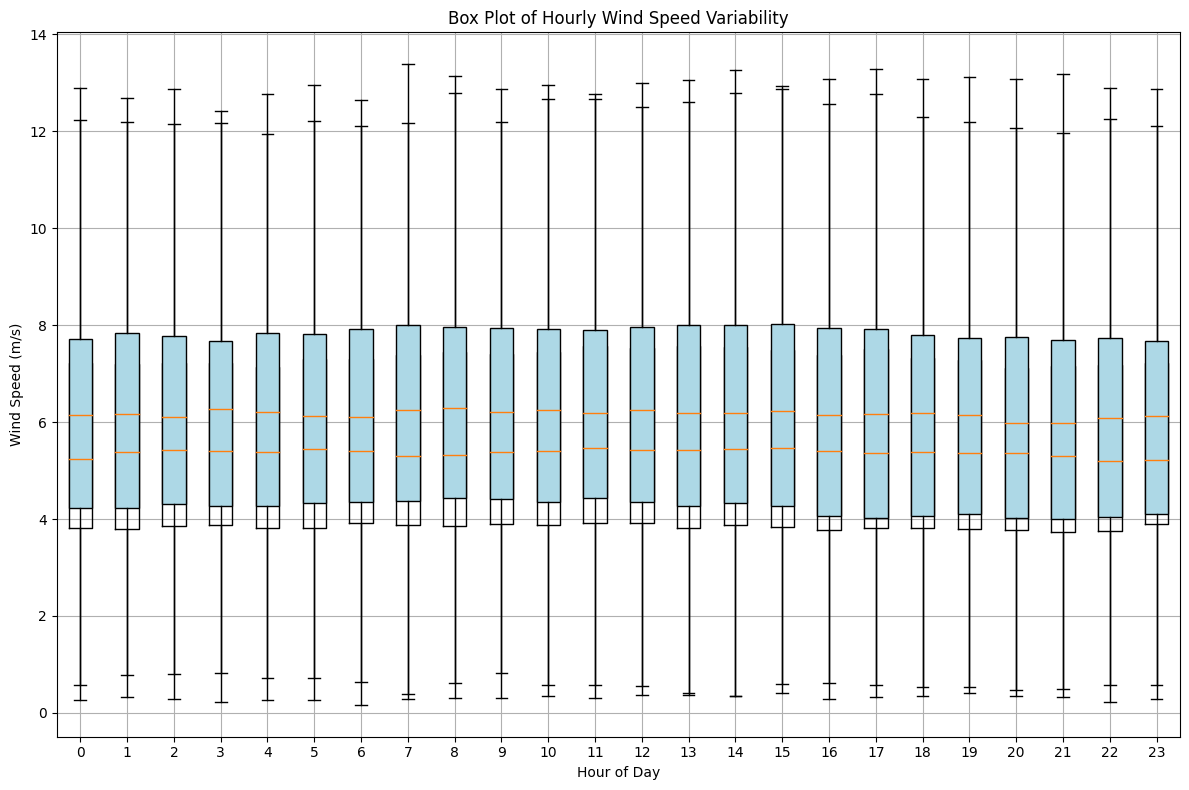

In [44]:
test_df['Hour'] = test_df['Date/time'].dt.hour

plt.figure(figsize=(12, 8))
plt.boxplot([test_df[test_df['Hour'] == hour]['Actual'] for hour in range(24)], positions=range(24), showfliers=False, widths=0.5)
plt.boxplot([test_df[test_df['Hour'] == hour]['Predicted'] for hour in range(24)], positions=range(24), showfliers=False, widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Hourly Wind Speed Variability')
plt.xlabel('Hour of Day')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(range(24), range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


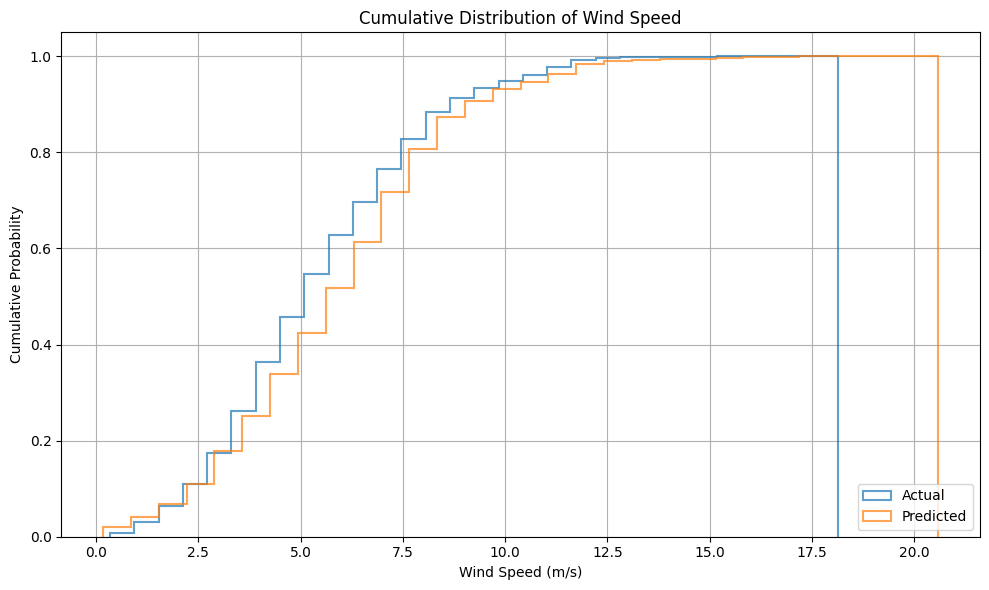

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(test_Y.flatten(), bins=30, cumulative=True, density=True, alpha=0.7, label='Actual', histtype='step', linewidth=1.5)
plt.hist(test_predict.flatten(), bins=30, cumulative=True, density=True, alpha=0.7, label='Predicted', histtype='step', linewidth=1.5)
plt.title('Cumulative Distribution of Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Cumulative Probability')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


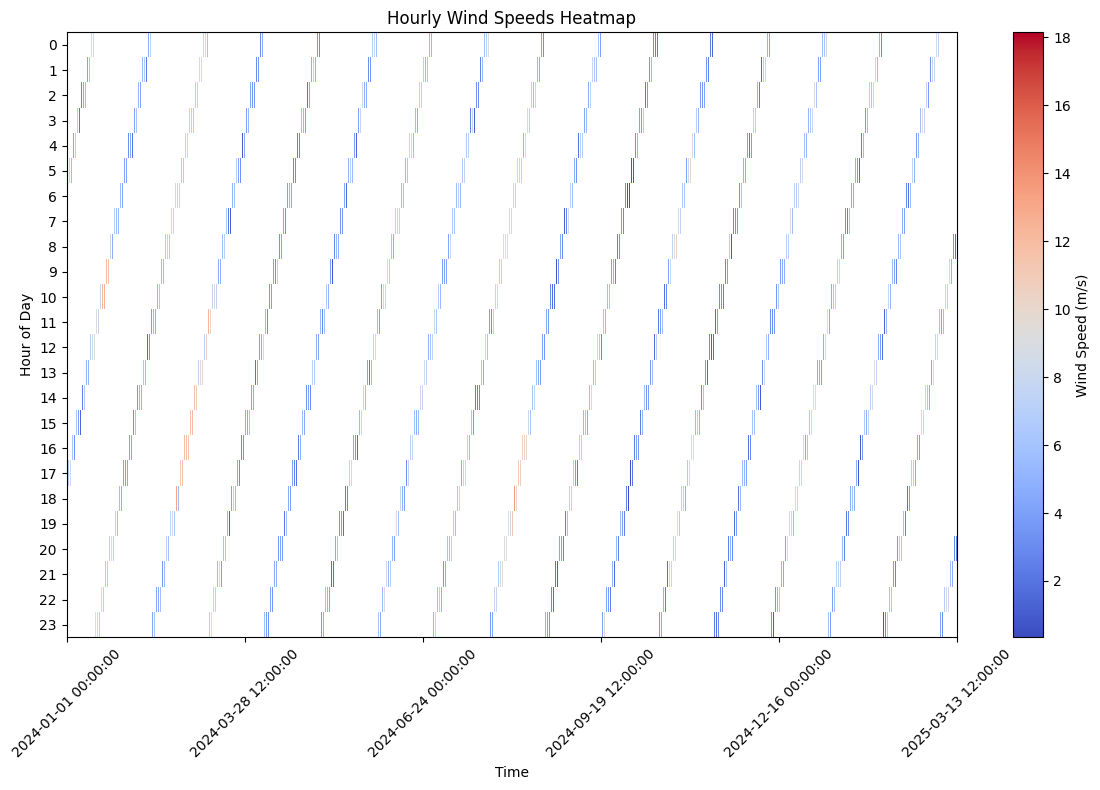

In [46]:
hourly_data = test_df.pivot_table(index='Hour', columns='Date/time', values='Actual')

plt.figure(figsize=(12, 8))
plt.imshow(hourly_data, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Wind Speed (m/s)')
plt.title('Hourly Wind Speeds Heatmap')
plt.xlabel('Time')
plt.ylabel('Hour of Day')
plt.xticks(range(0, len(hourly_data.columns), int(len(hourly_data.columns)/5)), hourly_data.columns[::int(len(hourly_data.columns)/5)].strftime('%Y-%m-%d %H:%M:%S'), rotation=45)
plt.yticks(range(len(hourly_data.index)), hourly_data.index)
plt.tight_layout()
plt.show()


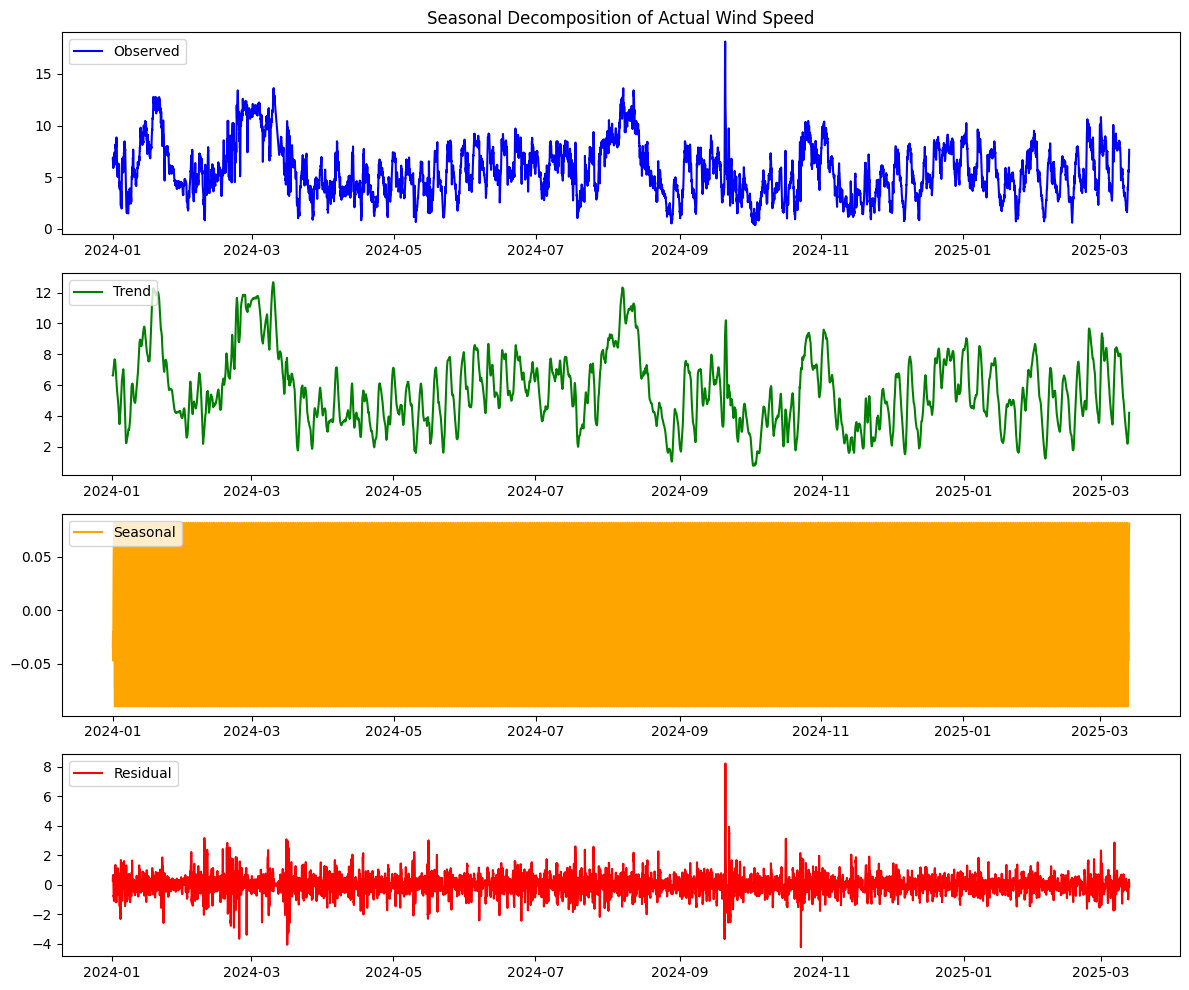

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(test_df.set_index('Date/time')['Actual'], model='additive', period=24)

plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend(loc='upper left')
plt.title('Seasonal Decomposition of Actual Wind Speed')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


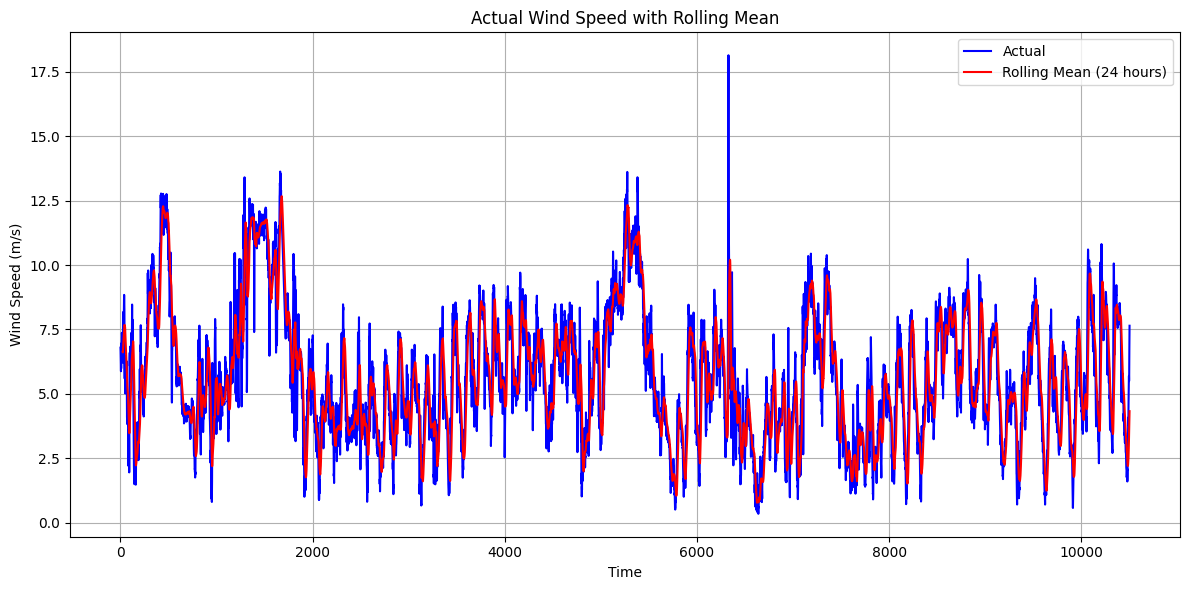

In [49]:
rolling_mean = test_df['Actual'].rolling(window=24).mean()  # Example: 24-hour rolling mean

plt.figure(figsize=(12, 6))
plt.plot(test_df['Actual'], label='Actual', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (24 hours)', color='red')
plt.title('Actual Wind Speed with Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

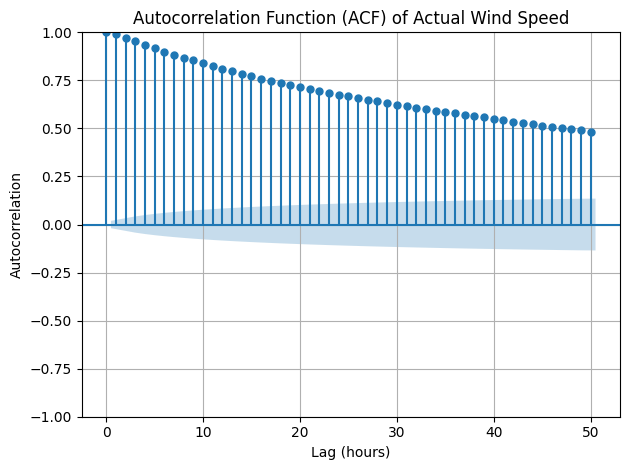

In [50]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(test_df['Actual'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of Actual Wind Speed')
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()
